<a href="https://colab.research.google.com/github/wojciech-baraniak05/2024Z-DataVisualizationTechniques/blob/main/Projekt_Uczenie_Maszynowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pycaret
!pip install google.cloud


In [ ]:
!pip install optuna
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.8 MB/s eta 0:00:00


In [ ]:
from google.cloud import bigquery
from google.colab import auth

import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            fbeta_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, f1_score, make_scorer)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.base import clone

from xgboost import XGBClassifier

from sklearn.metrics import   make_scorer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import optuna
import shap


# from pycaret.classification import *


In [ ]:
auth.authenticate_user()
project_id = "projekt-analiza-danych"
client = bigquery.Client(project=project_id, location="EU")
#fragment kodu do znajdywania danych
# datasets = list(client.list_datasets('projekt-analiza-danych'))
# print([dataset.dataset_id for dataset in datasets])
# tables = list(client.list_tables('projekt-analiza-danych.Projekt_ML'))
# print([table.table_id for table in tables])
dataset_ref = client.dataset('Projekt_ML', project=project_id)
dataset = client.get_dataset(dataset_ref)

table_ref = dataset.table('creditcard_csv')
df = client.get_table(table_ref)
df = client.list_rows(df).to_dataframe()

### Kod do wczytywania danych może się długo ładować ( ~ 4 minuty )

In [ ]:
# project_id = "projekt-analiza-danych"
# client = bigquery.Client(project=project_id, location="EU")

# table_id = "projekt-analiza-danych.Projekt_ML.creditcard_csv"

# # Force it to NOT use the BigQuery Storage API
# df = client.list_rows(table_id).to_dataframe(create_bqstorage_client=False)

# df.head()


RefreshError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x788dd7a2b710>)

In [ ]:
df = df.drop(columns=['Time'])
df_vis, _ = train_test_split(df, test_size=0.4, random_state=42, stratify=df['Class'])
X = df.drop(columns=['Class'])
y = df['Class']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# # Podział tymczasowego zbioru na testowy (20%) i walidacyjny (20%)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
df_vis

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
108772,1.918433,-0.449334,0.008708,0.258078,-0.659465,0.238487,-0.918570,0.209128,1.151000,-0.040423,...,0.139183,0.557954,0.282220,0.777296,-0.374290,-0.469009,0.054887,-0.025848,11.03,0
265672,0.027577,-1.625342,0.715549,-1.641478,-2.082257,0.683241,-0.477662,-0.768189,-2.027405,1.075102,...,0.538221,-1.127254,0.427444,-0.487946,0.502059,-0.183429,0.108220,0.241177,324.90,0
178507,-0.313615,0.599908,1.488558,2.079885,0.012554,0.560240,0.260900,0.277219,-0.662202,0.253456,...,0.086984,0.371842,-0.032575,0.013176,-0.320598,-0.037517,0.190058,0.141410,44.32,0
102551,1.162061,-0.388315,1.126597,-0.475576,-1.214370,-0.516046,-0.794830,0.062305,3.242062,-1.468436,...,-0.119606,0.108540,0.049249,0.334251,0.320355,-0.713227,0.074737,0.028351,11.85,0
176654,0.456315,-0.685660,0.144606,-2.971778,-0.442659,0.182009,-0.629546,-0.847319,-2.126820,0.899248,...,0.618838,-0.350639,-0.151168,0.271576,0.870501,-0.207070,0.158479,0.226703,39.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,-0.806924,0.985300,1.083525,-1.176312,-0.678492,-1.167162,0.097048,0.399496,0.139810,-0.744806,...,-0.057487,-0.344062,0.038460,0.400127,-0.274599,0.715132,-0.092635,0.001381,0.23,0
225947,1.893078,-0.009979,-1.888811,0.582461,0.215590,-1.410979,0.439933,-0.447039,0.490484,-0.574373,...,0.242167,0.703296,-0.127425,-0.160970,0.261366,-0.106007,-0.014202,-0.013267,93.66,0
85214,-2.728180,2.146682,0.498205,1.053374,-0.631301,-0.324433,0.290786,0.332811,1.489076,2.349646,...,-0.288777,0.084453,0.007569,0.333398,0.058222,-0.324600,-0.124893,-0.091840,9.46,0
28969,1.280171,0.291302,0.275947,0.577749,0.186884,0.003056,-0.129425,-0.091854,1.388779,-0.477979,...,-0.436119,-0.973076,0.074974,-0.833730,0.232457,0.137848,-0.040525,0.000535,1.29,0


In [ ]:
df_vis.info

<bound method DataFrame.info of               V1        V2        V3        V4        V5        V6        V7  \
108772 -0.138130  0.773805  0.203812 -0.842418  0.629780 -0.639030  1.015165   
265672 -1.579802  0.749193 -2.782770 -0.543318  0.311752 -1.787213  2.180315   
178507 -5.141843  0.353750 -1.757599 -0.509208 -0.995166 -1.618397 -1.046748   
102551 -2.208854 -0.312558  2.050289  0.146678  1.090548  1.286748 -0.893319   
176654  2.119581 -1.073131 -0.782762 -1.089587 -0.654998  0.235270 -1.118275   
...          ...       ...       ...       ...       ...       ...       ...   
3439   -0.557458  1.231524  0.573268 -0.263955  0.946120 -1.203171  1.057426   
225947 -0.031179  0.113149  1.510971  1.425654 -1.039487  1.751758 -2.090455   
85214  -0.959560  1.212048  0.837540 -0.291914  0.176942 -0.157210  0.283521   
28969   2.107363 -0.234690 -1.884170 -0.148625  0.581493 -0.070868 -0.080950   
17596  -0.357068  0.334361  1.973121 -1.021239  0.046268 -0.299830  0.441807   

              V8        V9       V10  ...       V21       V22       V23  \
108772 -0.188179  0.227870  0.312521  ... -0.327166 -0.606898  0.000068   
265672 -0.503126  0.131776  0.663094  ...  0.141306  1.668458  0.652207   
178507  2.066029 -0.536988 -0.302904  ... -0.423889 -1.645317 -0.985890   
102551  1.343548 -0.656640 -0.986669  ...  0.389543  0.593064 -0.105070   
176654  0.113024 -0.158830  0.877914  ...  0.359136  1.037512  0.089944   
...          ...       ...       ...  ...       ...       ...       ...   
3439   -0.130107 -1.042645 -1.188775  ...  0.025811  0.023363 -0.230233   
225947 -2.119718  1.116773 -0.923701  ... -1.082218  1.054041 -0.140903   
85214   0.472126 -0.820674 -0.280301  ... -0.170796 -0.565176  0.031464   
28969   0.018541  0.832859  0.124012  ...  0.229875  0.691585 -0.100587   
17596  -0.186710  0.533714 -0.789111  ...  0.072480  0.586523 -0.308511   

             V24       V25       V26       V27       V28  Amount  Class  
108772 -0.375887 -0.489973  0.121073  0.186048 -0.083945    9.73      0  
265672  0.165137 -0.935610  0.708223  0.617882  0.236259  181.88      0  
178507  0.094319 -0.186864  0.496440  0.376950 -0.478936   56.99      0  
102551 -1.049109 -0.001553 -0.412484  0.030739 -0.190530   15.00      0  
176654  0.267468 -0.110836 -0.111047  0.003208 -0.052363   29.95      0  
...          ...       ...       ...       ...       ...     ...    ...  
3439    0.224216 -0.088442  0.156625  0.071094  0.154123    0.76      0  
225947  0.461870  0.435087 -0.318645  0.237863  0.323876   71.90      0  
85214  -0.496681 -0.043369  0.096767  0.024428  0.024457   11.28      0  
28969  -0.323397  0.394607 -0.403761 -0.013278 -0.071056    1.00      0  
17596   0.003907 -0.267472  0.985999 -0.096340 -0.097249    1.00      0  

[170883 rows x 30 columns]>

Banki i instytucje finansowe codziennie przetwarzają ogromne ilości transakcji kartami kredytowymi. Niestety,
wśród nich zdarzają się transakcje które są oszustwem, które mogą prowadzić do strat finansowych zarówno dla klientów, jak i dla banków.
### Cel modelu
Stworzenie modelu uczenia maszynowego, który: <br>
- Automatycznie wykryje podejrzane transakcje na podstawie historycznych danych. <br>
- Ograniczy straty finansowe poprzez szybkie wykrywanie oszustw i możliwość ich natychmiastowej blokady. <br>
- Poprawi bezpieczeństwo klientów, eliminując nieautoryzowane transakcje.
- Bardziej problematyczne są dla banku oszustwa, niż błędne ocenienie dobrej transakcji

Najlepszą metryką do oceny modelu będzie RECALL, wyrażający się wzorem:
$$RECALL =  \frac{TP}{TP + FN}$$
gdzie **TP** określa, jak wiele oszustw zostało wykrytych,
a **FN** określa, jak wiele z oszustw zostało przeoczone <br>
Jednak takie rozwiązanie często będzie skutkowało z bardzo małą precyzją, dlatego została stworzona równierz metryka F3-score, która balansuje te dwie metryki i zwraca trzy krotnie większą wartość na recall niż na precission <br>
$$F_3 = \frac{1 + 3^2}{\frac{3^2}{recall} \frac{1}{precission}}$$
gdzie **precision** określa, jak wiele z przewidzianych pozytywnych przykładów jest rzeczywiście pozytywnych, <br>
a **recall** określa, jak wiele rzeczywistych pozytywnych przypadków zostało poprawnie wykrytych. <br>
To jaki ostateczny model będzie najlepszy zależy od strat związanych z błędem modelu. <br>

<!-- Alternatywnie można wykożystać metrykę **F2**, która optymalizuje model pod kątem **recall** <br> -->


 Straty jakie ponosi bank za oznaczenie oszustwa jako prawdziwe są zdecydowanie większe niż jeżeli oznaczymy prawdziwą transakcje jako oszustwo, jednak reputacja wsród klientów też ma znaczenie, więc należy znaleźć punkt, w którym zminimalizujemy straty spowodowane oszustwami, jak i straty związane z obsługą klienta kiedy transakcja zostanie odrzucona.
 ## Straty ponoszone przez banki
 Gdy płatność jest **FP** straty to:
 - Spadek lojalności klienta, w dłuższym czasie może prowadzić do przeniesienia sie klienta do innego banku <br>
 - Koszty związane z obługą klienta



Jeśli jednak płatność jest **FN**:
- Banki poniosą koszty tranzakcji, według wstępnej analizy - średni koszt oszukanej transakcji to około 10€
- Koszt śledztwa
- Utrata reputacji
- [Każdy skradziony dolar, to strata $4.41 dolara dla banku](https://risk.lexisnexis.com/about-us/press-room/press-release/20240424-tcof-financial-services-lending?utm_source=chatgpt.com)


In [ ]:
df_vis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170883 entries, 108772 to 17596
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      170883 non-null  float64
 1   V2      170883 non-null  float64
 2   V3      170883 non-null  float64
 3   V4      170883 non-null  float64
 4   V5      170883 non-null  float64
 5   V6      170883 non-null  float64
 6   V7      170883 non-null  float64
 7   V8      170883 non-null  float64
 8   V9      170883 non-null  float64
 9   V10     170883 non-null  float64
 10  V11     170883 non-null  float64
 11  V12     170883 non-null  float64
 12  V13     170883 non-null  float64
 13  V14     170883 non-null  float64
 14  V15     170883 non-null  float64
 15  V16     170883 non-null  float64
 16  V17     170883 non-null  float64
 17  V18     170883 non-null  float64
 18  V19     170883 non-null  float64
 19  V20     170883 non-null  float64
 20  V21     170883 non-null  float64
 21  V22     170

### Podstawowe informacje o zbiorze danych:
Liczba próbek: 170883  <br>
Liczba kolumn: 31 <br>
Brakujące wartości: brak (wszystkie kolumny mają pełne dane) <br>
Dane zawierają: <br>
Czas („Time”) <br>
28 zanonimizowanych cech PCA („V1” – „V28”) <br>
Kwotę transakcji („Amount”) <br>
Etykietę klasyfikacji („Class”): 0 – transakcja normalna, 1 – oszustwo <br>
### Podstawowe statystyki: <br>
Kwota transakcji: <br>
Średnia: 88.35 <br>
Mediana: 22.00 <br>
Maksymalna wartość: 25,691.16 <br>
Czas: <br>
Rozkład od 0 do 172,792 sekund (transakcje w ciągu dwóch dni) <br>
Cechy V1-V28: <br>
Średnia bliska 0 (charakterystyczne dla PCA) <br>
Wartości w szerokim zakresie (np. V1: od -56.41 do 2.45) <br>

In [ ]:
df_vis.describe().map(lambda x: f"{x:.2f}")

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,...,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00,170883.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,...,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,88.45,0.00
std,1.96,1.65,1.52,1.42,1.39,1.34,1.25,1.21,1.10,1.09,...,0.75,0.73,0.63,0.61,0.52,0.48,0.41,0.34,250.83,0.04
min,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.32,-24.59,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.53,-22.57,-15.43,0.00,0.00
25%,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.56,-0.21,-0.64,-0.53,...,-0.23,-0.54,-0.16,-0.36,-0.32,-0.33,-0.07,-0.05,5.69,0.00
50%,0.02,0.06,0.18,-0.02,-0.06,-0.27,0.04,0.02,-0.05,-0.09,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.08,0.00
75%,1.32,0.80,1.02,0.75,0.61,0.40,0.57,0.33,0.60,0.45,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.80,0.00
max,2.45,22.06,9.38,16.72,34.80,73.30,120.59,19.17,15.59,23.75,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


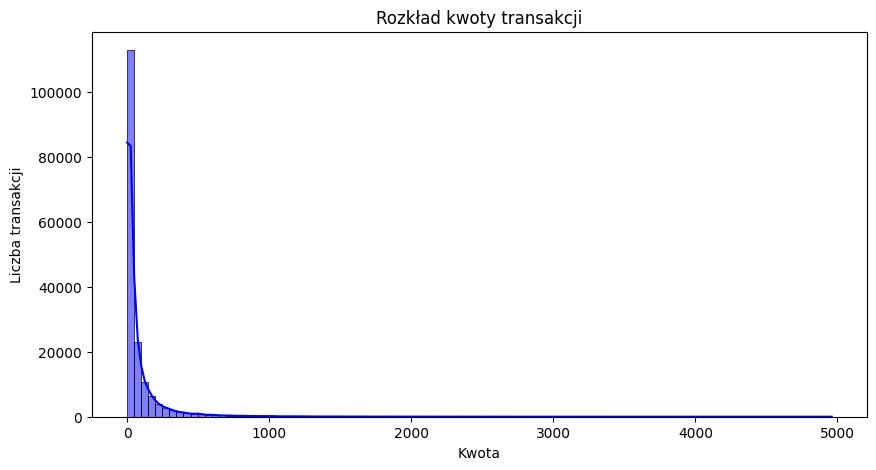

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_vis[df_vis['Amount'] < 5000]['Amount'], bins=100, kde=True, color='blue')  # Ograniczenie do 5000 dla lepszej wizualizacji
plt.title('Rozkład kwoty transakcji')
plt.xlabel('Kwota')
plt.ylabel('Liczba transakcji')
plt.show()

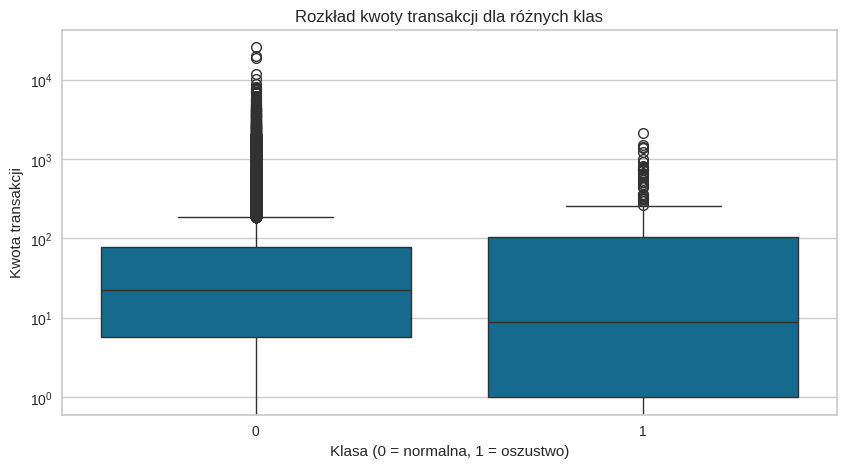

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_vis['Class'], y=df_vis['Amount'])
plt.title('Rozkład kwoty transakcji dla różnych klas')
plt.xlabel('Klasa (0 = normalna, 1 = oszustwo)')
plt.ylabel('Kwota transakcji')
plt.yscale('log')  # Skala logarytmiczna dla lepszej wizualizacji
plt.show()

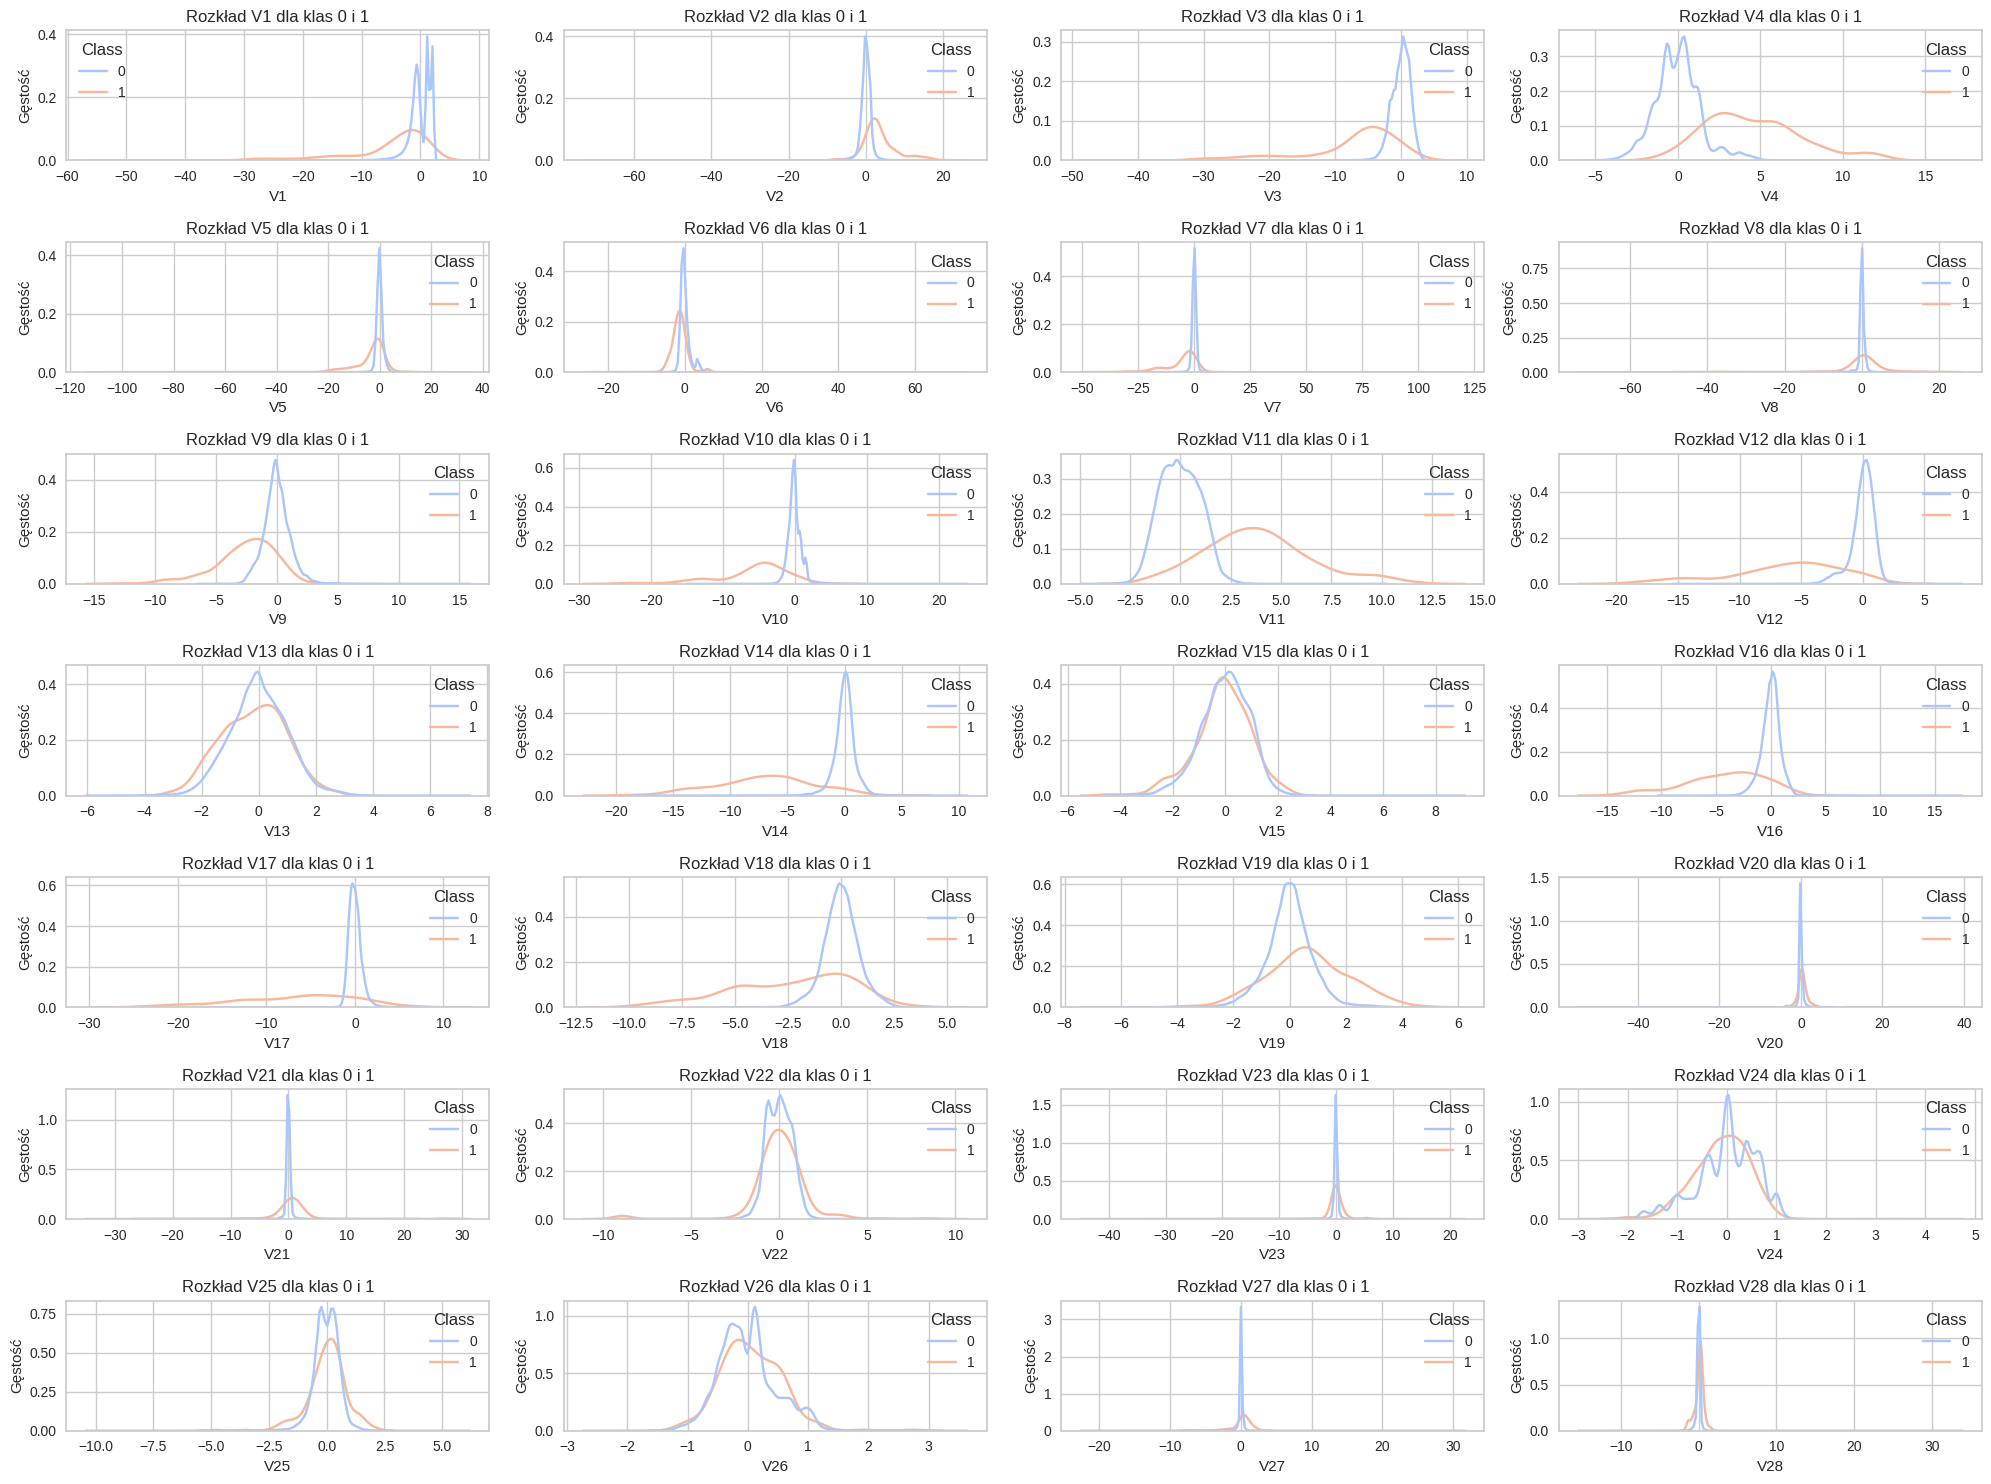

In [ ]:
columns_to_plot = [f'V{i}' for i in range(1, 29)]

plt.figure(figsize=(20, 15))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(7, 4, i)
    sns.kdeplot(data=df_vis, x=column, hue='Class', palette='coolwarm', common_norm=False)
    plt.title(f'Rozkład {column} dla klas 0 i 1')
    plt.xlabel(column)
    plt.ylabel('Gęstość')

plt.tight_layout()
plt.show()

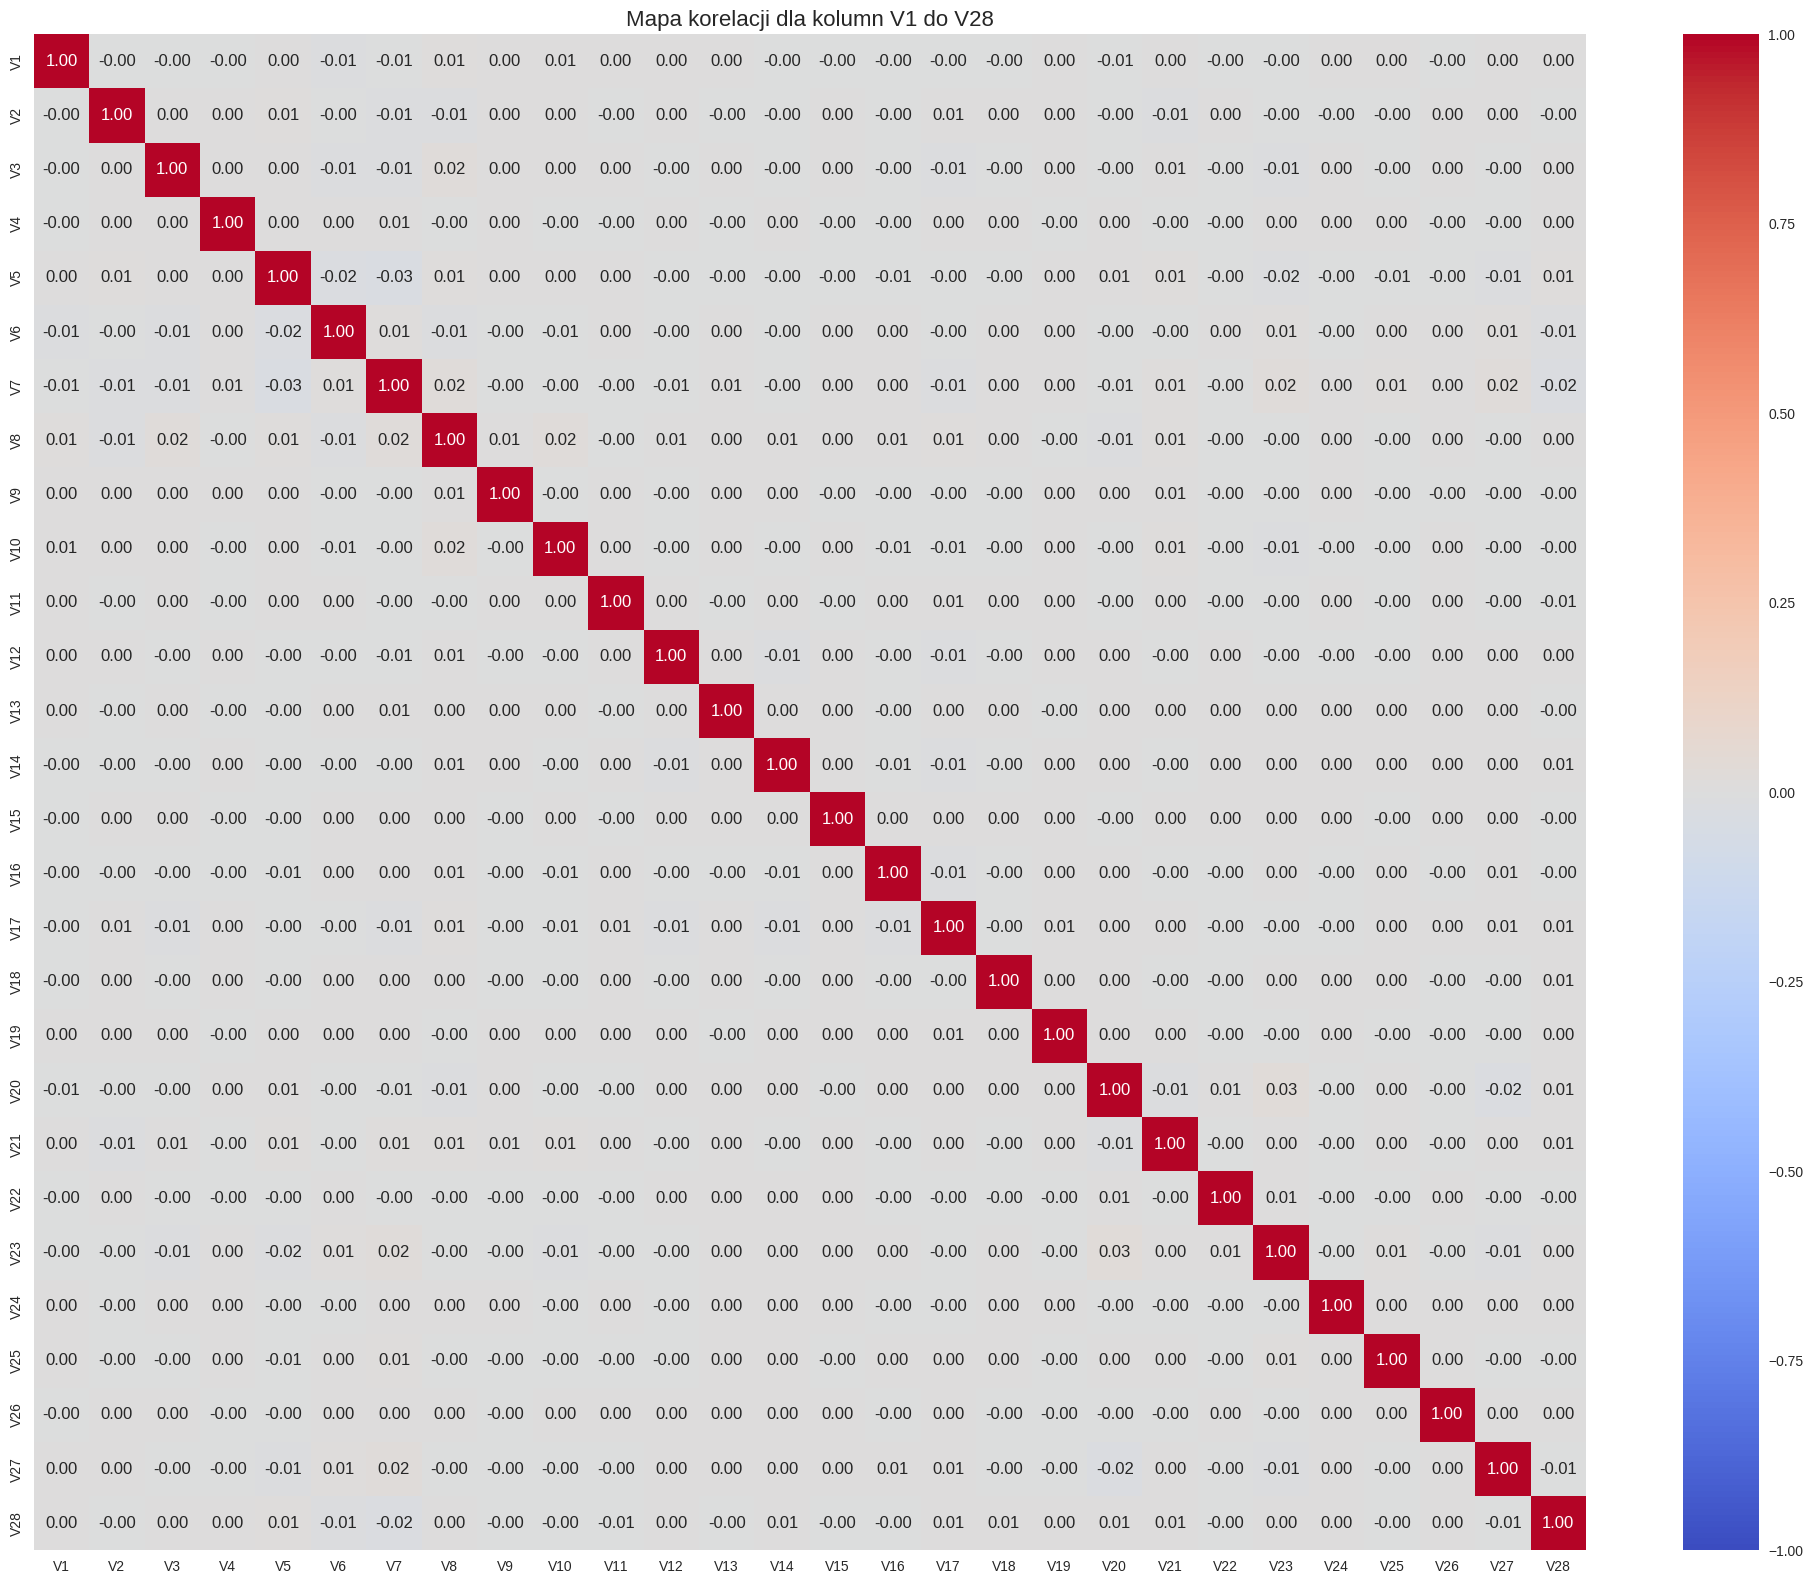

In [ ]:
columns_to_plot = [f'V{i}' for i in range(1, 29)]

corr_matrix = df_vis[columns_to_plot].corr()

plt.figure(figsize=(20, 16))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa korelacji dla kolumn V1 do V28', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
ilość_oszustw = y_train.sum()
procent_oszustw = (ilość_oszustw / len(y_train)) * 100

print(f"Procent oszustw w zbiorze treningowym: {procent_oszustw:.2f}%")

Procent oszustw w zbiorze treningowym: 0.17%


In [ ]:
X['Amount'].describe().map(lambda x: f"{x:.2f}")

,Amount
count,284806.00
mean,0.00
std,1.00
min,-0.35
25%,-0.33
50%,-0.27
75%,-0.04
max,102.36


In [ ]:
X_n = df_vis

## Funkcje generująca ocenę modeli

In [ ]:
def evaluate_with_smote(model, model_name, X_train, y_train, X_test, y_test):
    """Evaluate model with SMOTE resampling applied to training data"""

    # Apply SMOTE to training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train model
    model.fit(X_train_resampled, y_train_resampled)

    # Generate predictions
    y_hat = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_hat),
        'precision': precision_score(y_test, y_hat),
        'recall': recall_score(y_test, y_hat),
        'f1': f1_score(y_test, y_hat),
        'f3': fbeta_score(y_test, y_hat, beta=3),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    }

    print(f"\n{model_name} WITH SMOTE - Test Set Evaluation:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    # Generate plots if probabilities are available
    if y_prob is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax1, cmap='Blues')
        ax1.set_title('Confusion Matrix')

        # ROC Curve
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax2)
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_title(f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax3)
        no_skill = len(y_test[y_test==1]) / len(y_test)
        ax3.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax3.set_title('Precision-Recall Curve')

        plt.suptitle(f'{model_name} WITH SMOTE Evaluation', y=1.02)
        plt.tight_layout()
        plt.show()

    return metrics


def evaluate_without_smote(model, model_name, X_train, y_train, X_test, y_test):
    """Evaluate model without any resampling of training data"""

    # Train model on original imbalanced data
    model.fit(X_train, y_train)

    # Generate predictions
    y_hat = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_hat),
        'precision': precision_score(y_test, y_hat),
        'recall': recall_score(y_test, y_hat),
        'f1': f1_score(y_test, y_hat),
        'f3': fbeta_score(y_test, y_hat, beta=3),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    }

    print(f"\n{model_name} WITHOUT SMOTE - Test Set Evaluation:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

    # Generate plots if probabilities are available
    if y_prob is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax1, cmap='Reds')
        ax1.set_title('Confusion Matrix')

        # ROC Curve
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax2)
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_title(f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax3)
        no_skill = len(y_test[y_test==1]) / len(y_test)
        ax3.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax3.set_title('Precision-Recall Curve')

        plt.suptitle(f'{model_name} WITHOUT SMOTE Evaluation', y=1.02)
        plt.tight_layout()
        plt.show()

    return metrics


Logistic Regression WITH SMOTE - Test Set Evaluation:
accuracy: 0.9722
precision: 0.0518
recall: 0.8687
f1: 0.0978
f3: 0.3373
roc_auc: 0.9610


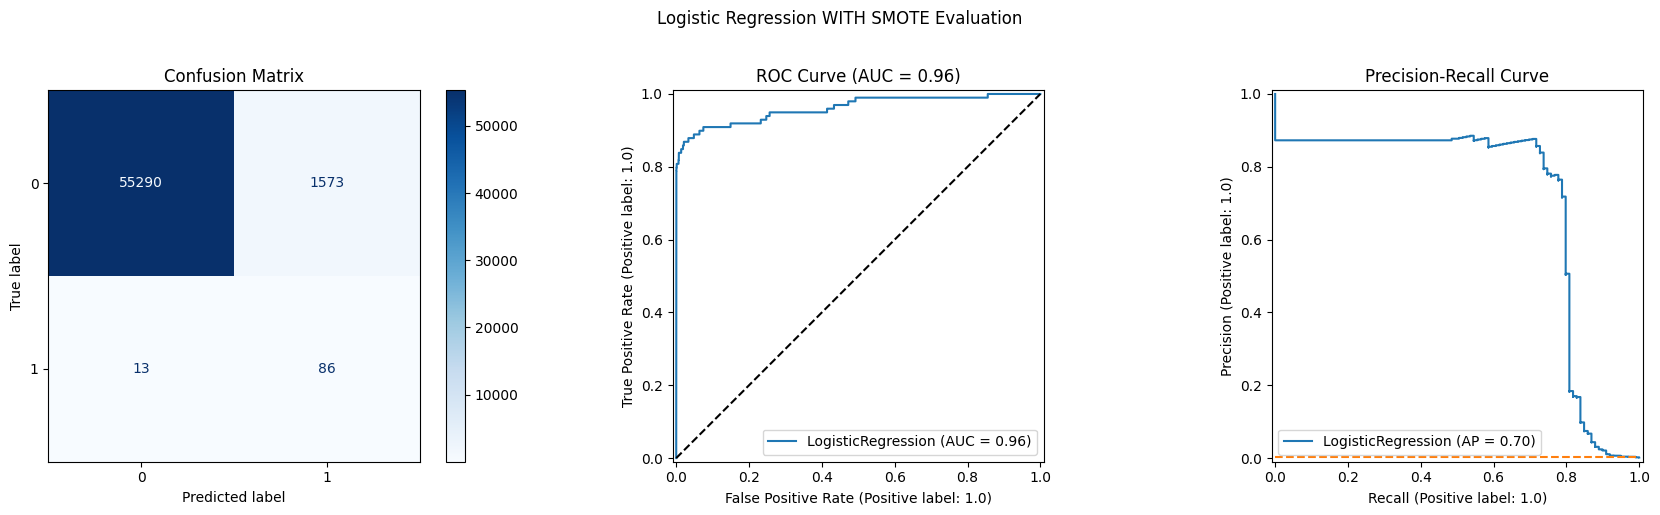


Logistic Regression WITHOUT SMOTE - Test Set Evaluation:
accuracy: 0.9991
precision: 0.8358
recall: 0.5657
f1: 0.6747
f3: 0.5846
roc_auc: 0.9673


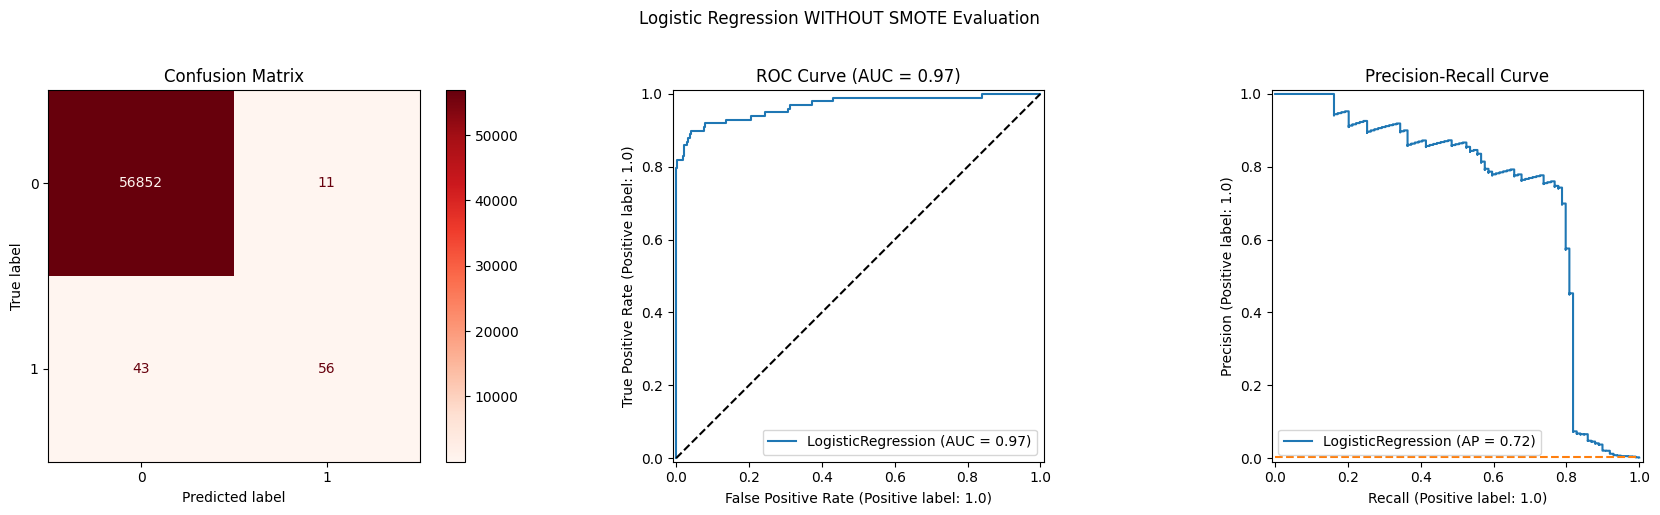


Decision Tree WITH SMOTE - Test Set Evaluation:
accuracy: 0.9970
precision: 0.3378
recall: 0.7677
f1: 0.4691
f3: 0.6810
roc_auc: 0.8825


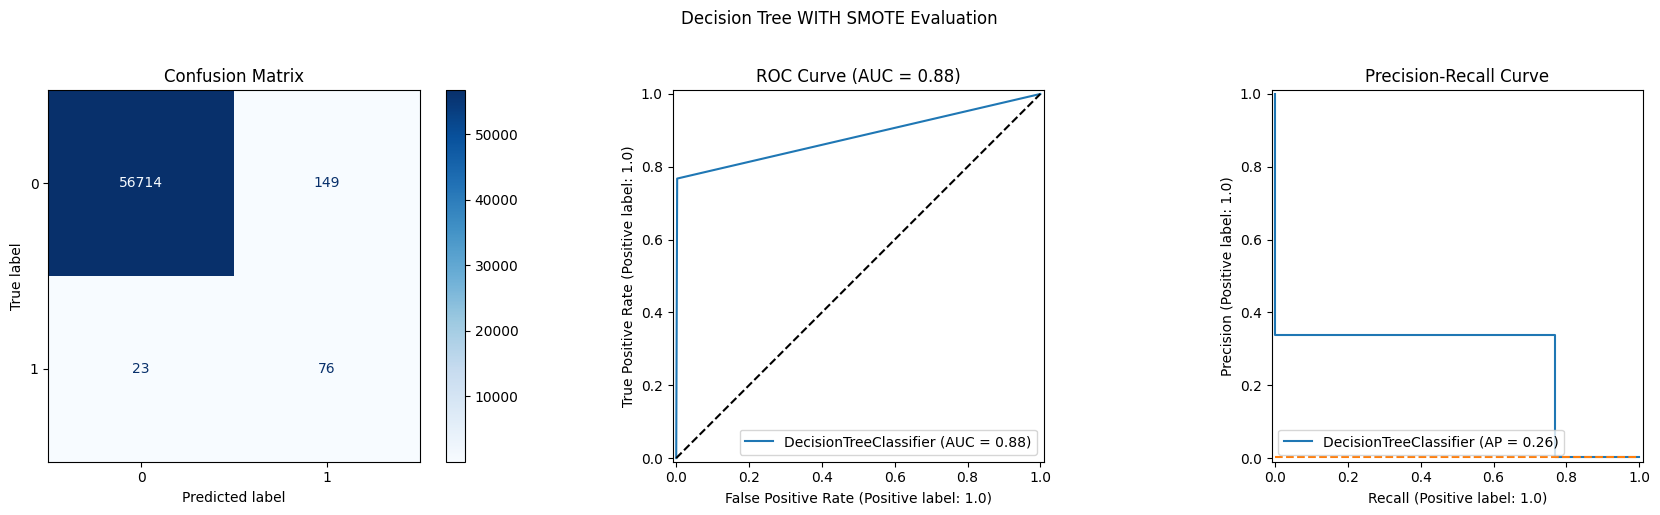


Decision Tree WITHOUT SMOTE - Test Set Evaluation:
accuracy: 0.9990
precision: 0.7143
recall: 0.7071
f1: 0.7107
f3: 0.7078
roc_auc: 0.8533


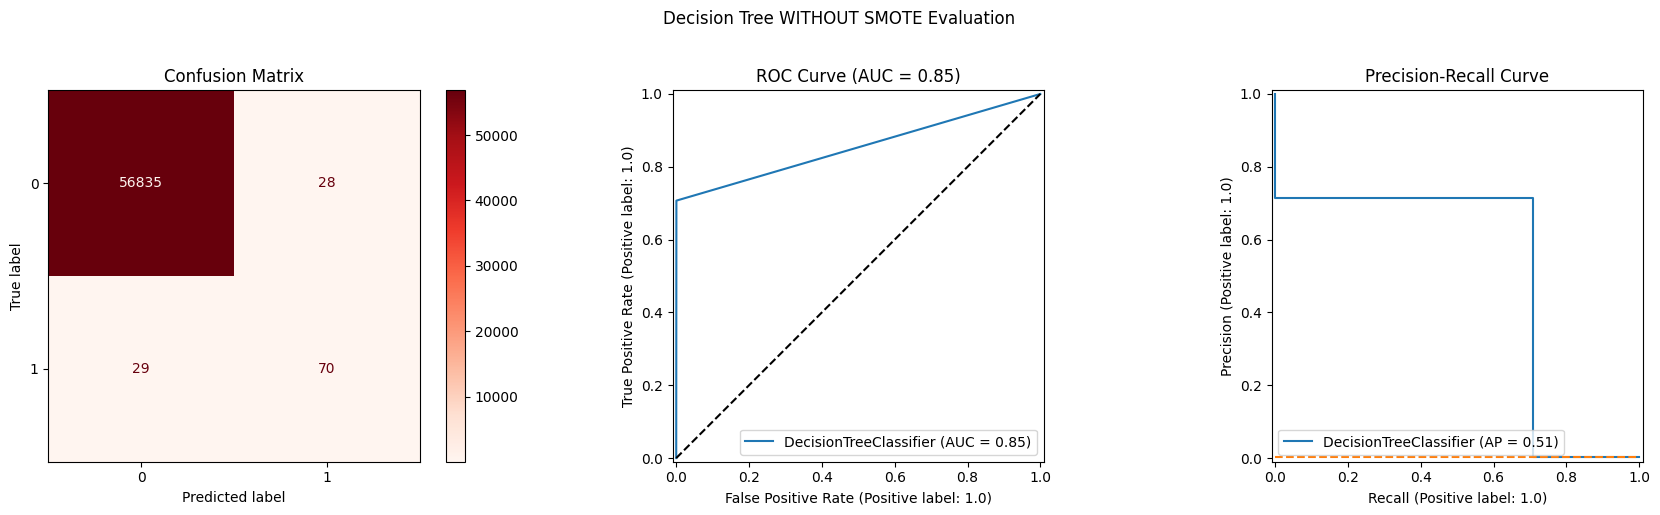


Naive Bayes WITH SMOTE - Test Set Evaluation:
accuracy: 0.9757
precision: 0.0565
recall: 0.8283
f1: 0.1057
f3: 0.3500
roc_auc: 0.9324


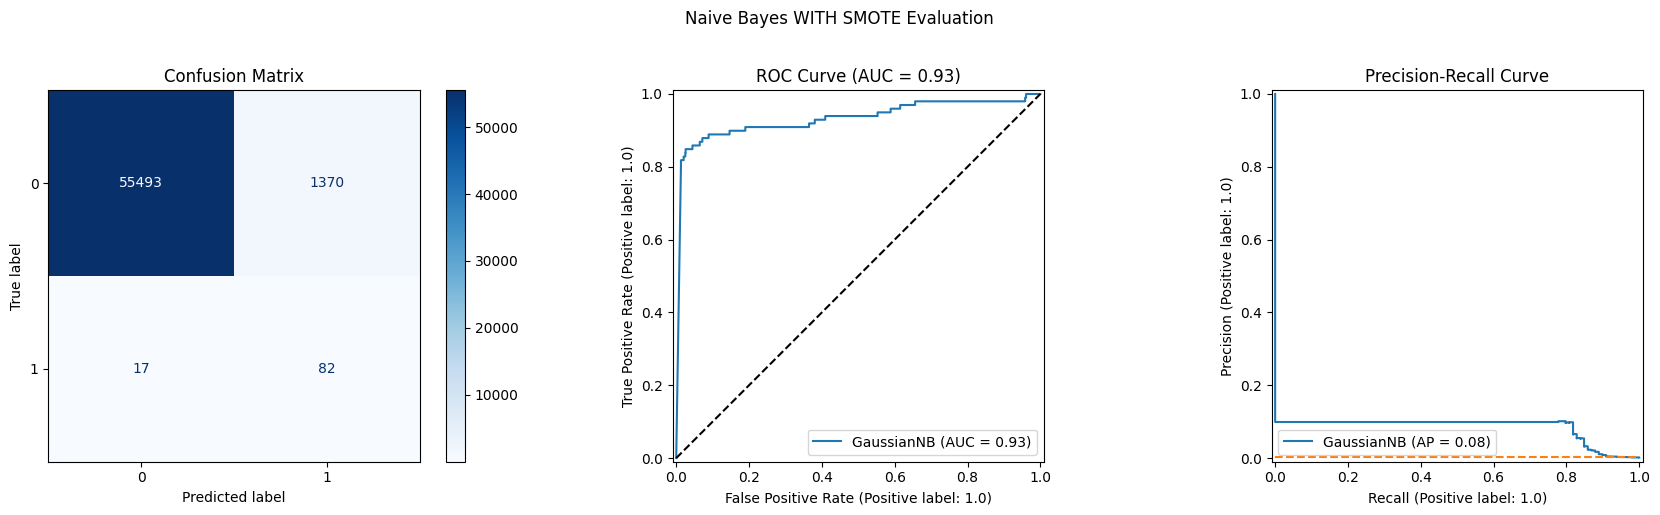


Naive Bayes WITHOUT SMOTE - Test Set Evaluation:
accuracy: 0.9772
precision: 0.0594
recall: 0.8182
f1: 0.1108
f3: 0.3594
roc_auc: 0.9514


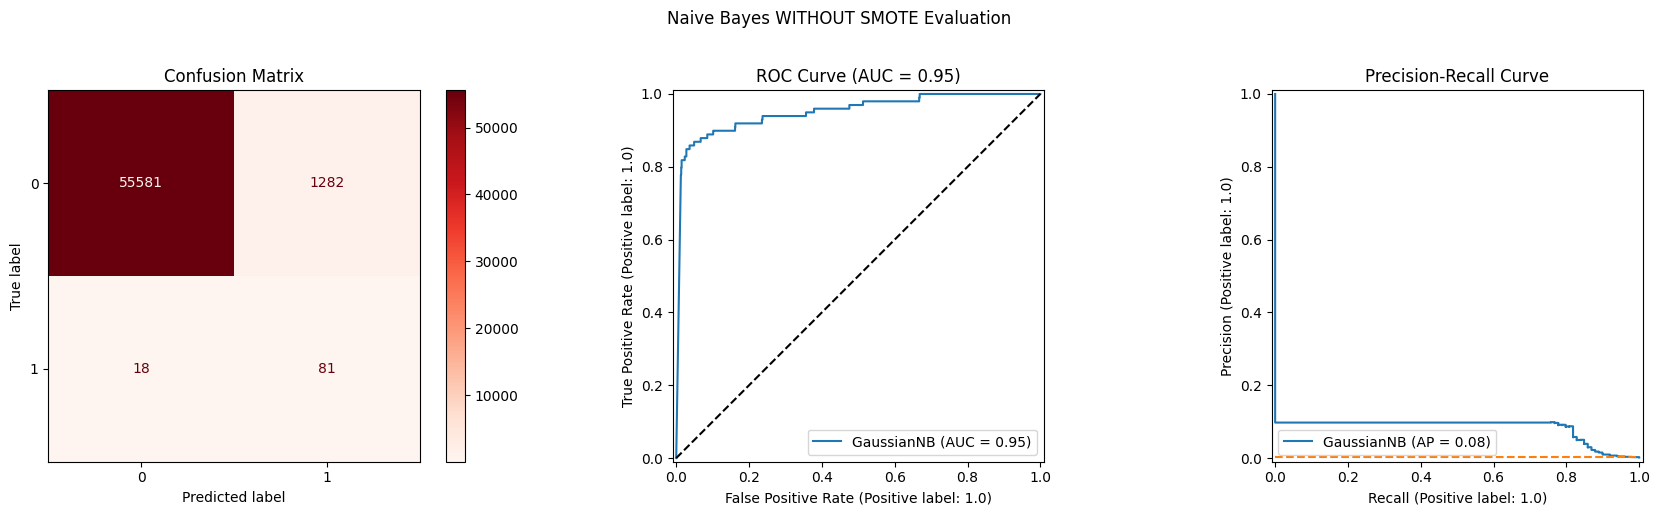


Logistic Regression Test Set Evaluation:
accuracy: 0.9721
precision: 0.0518
recall: 0.8687
f1: 0.0977
f3: 0.3370
roc_auc: 0.9613


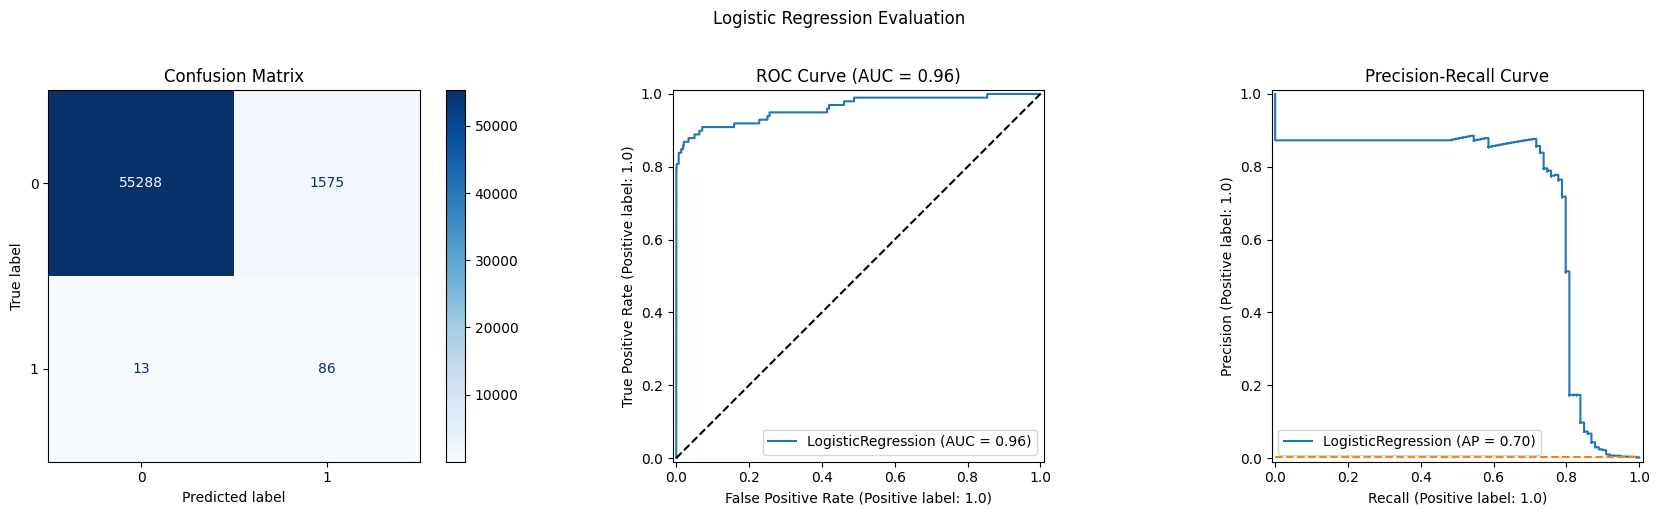


Decision Tree Test Set Evaluation:
accuracy: 0.9972
precision: 0.3632
recall: 0.7778
f1: 0.4952
f3: 0.6981
roc_auc: 0.8877


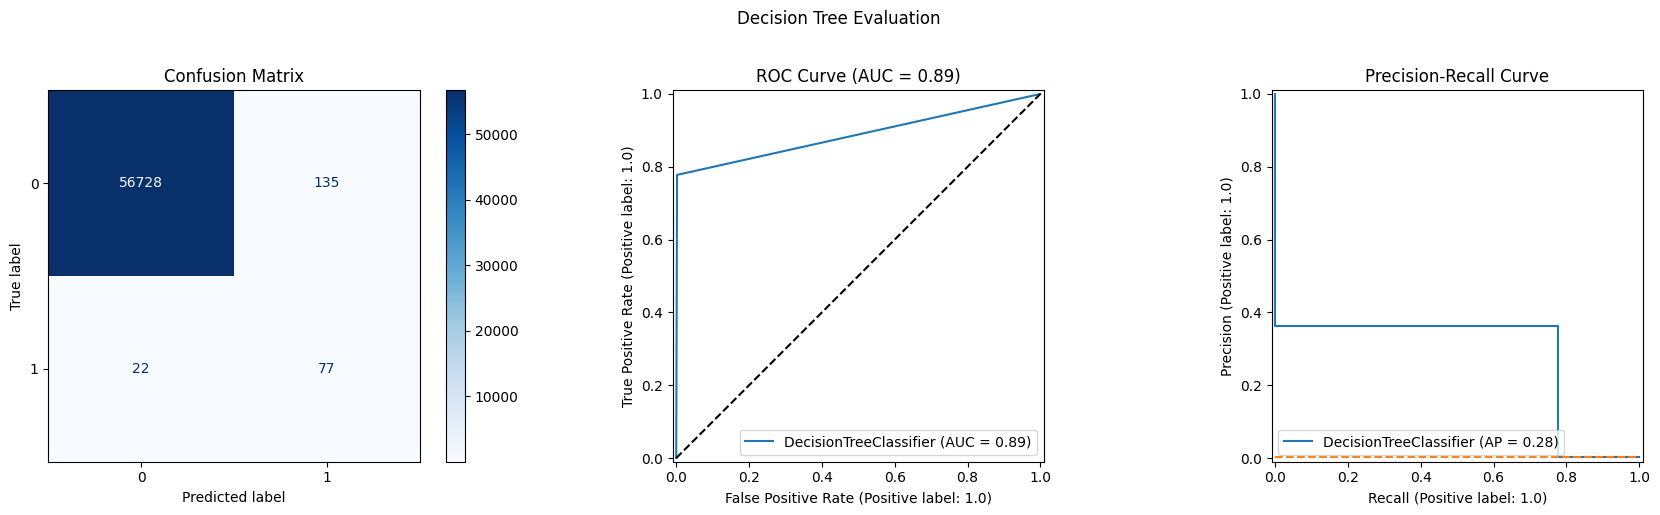


Naive Bayes Test Set Evaluation:
accuracy: 0.9756
precision: 0.0564
recall: 0.8283
f1: 0.1057
f3: 0.3498
roc_auc: 0.9323


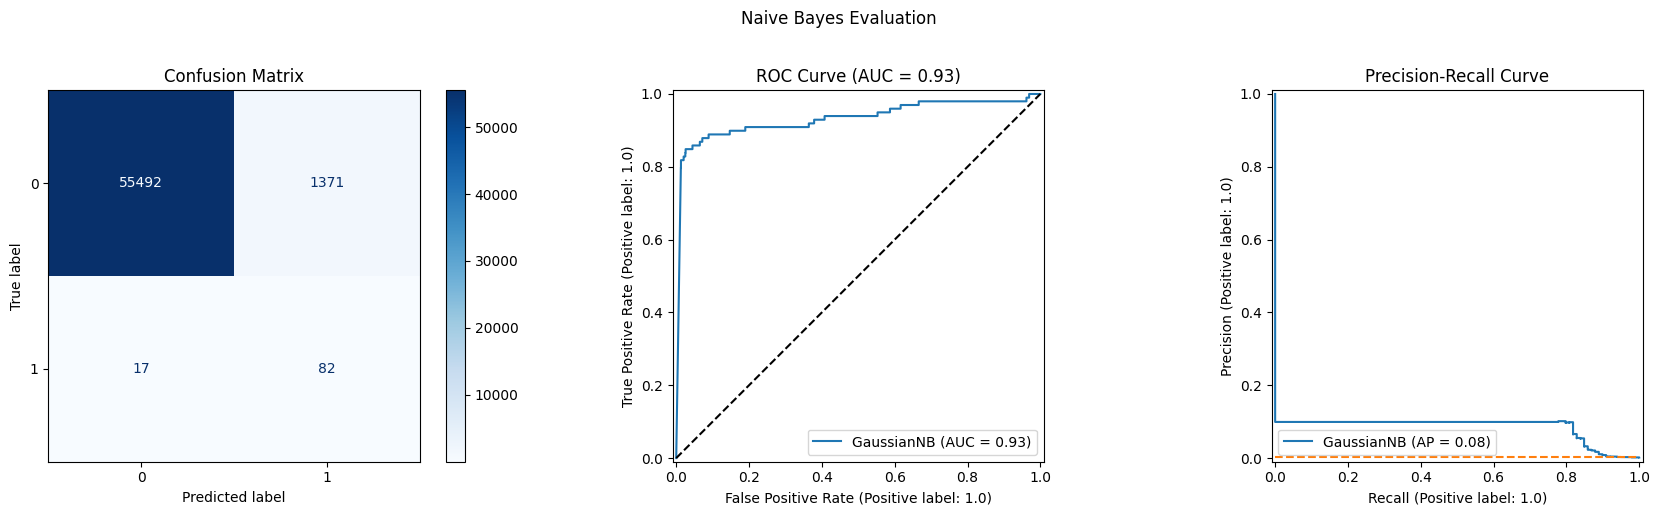

In [ ]:
models = {
    "Regresja logistyczna": LogisticRegression(max_iter=1000, random_state=42),
    "Drzewo decyzyjne": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    model_smote = clone(model)
    model_no_smote = clone(model)


    smote_metrics = evaluate_with_smote(model_smote, name, X_train, y_train, X_test, y_test)
    no_smote_metrics = evaluate_without_smote(model_no_smote, name, X_train, y_train, X_test, y_test)

for name, model in models.items():
    evaluate_model(model, name, X_train_resampled, y_train_resampled, X_test, y_test)


Random Forest WITH SMOTE - Test Set Evaluation:
accuracy: 0.9994
precision: 0.8556
recall: 0.7778
f1: 0.8148
f3: 0.7849
roc_auc: 0.9546


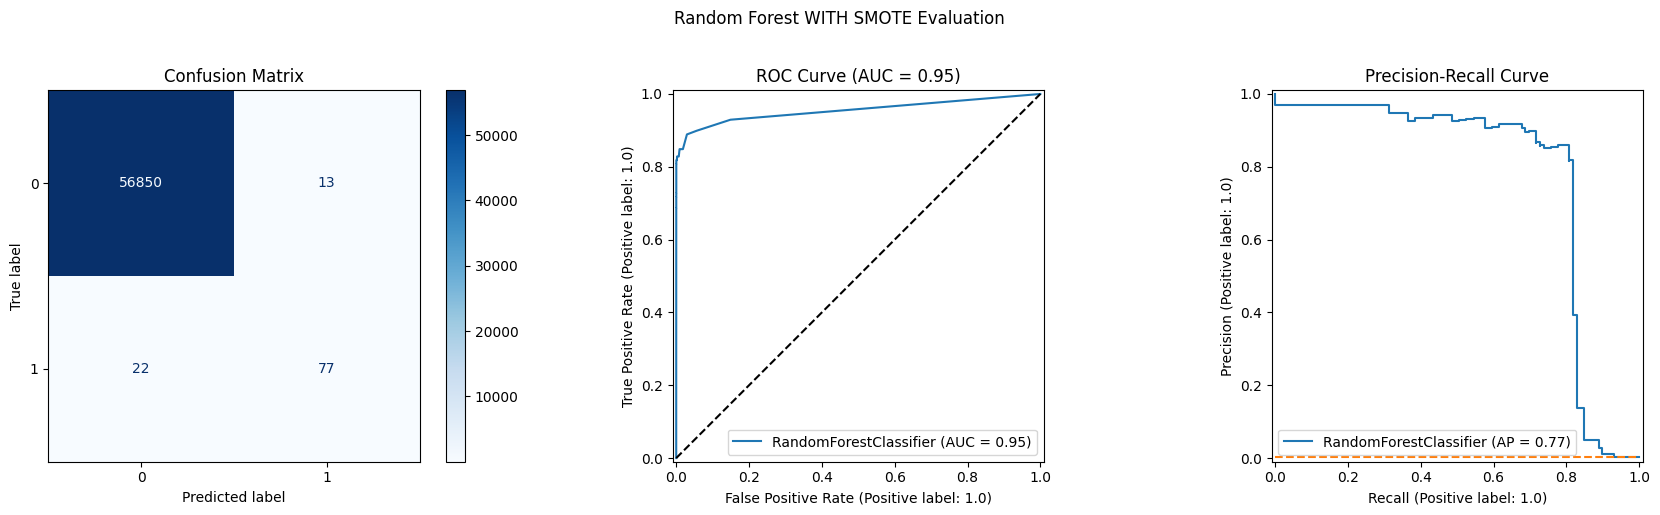


Random Forest WITHOUT SMOTE - Test Set Evaluation:
accuracy: 0.9994
precision: 0.8875
recall: 0.7172
f1: 0.7933
f3: 0.7312
roc_auc: 0.9273


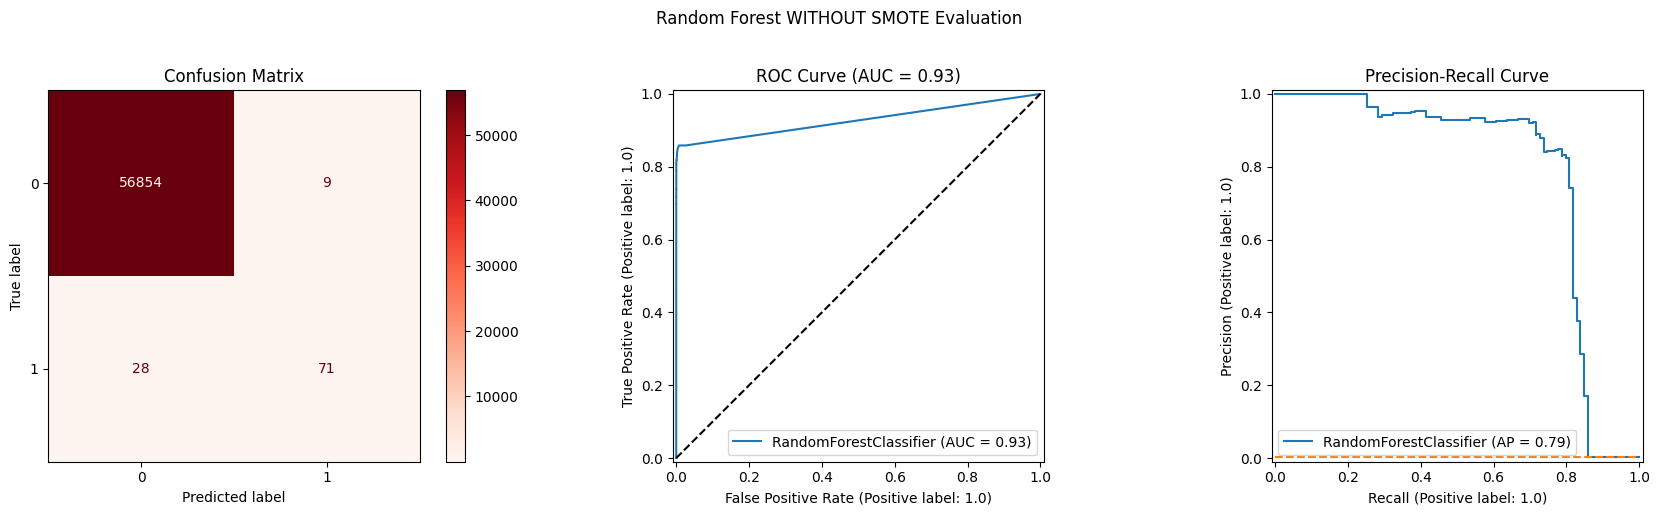

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:00:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost WITH SMOTE - Test Set Evaluation:
accuracy: 0.9991
precision: 0.7222
recall: 0.7879
f1: 0.7536
f3: 0.7808
roc_auc: 0.9530


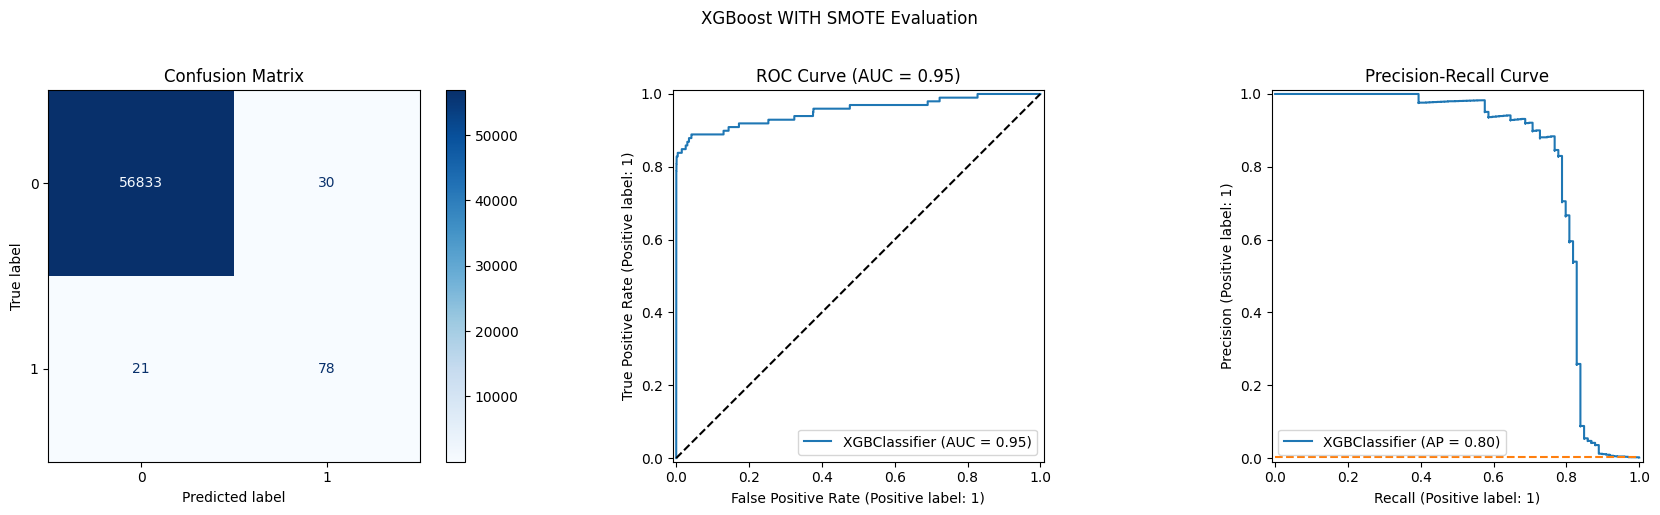

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:00:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost WITHOUT SMOTE - Test Set Evaluation:
accuracy: 0.9994
precision: 0.8916
recall: 0.7475
f1: 0.8132
f3: 0.7598
roc_auc: 0.9594


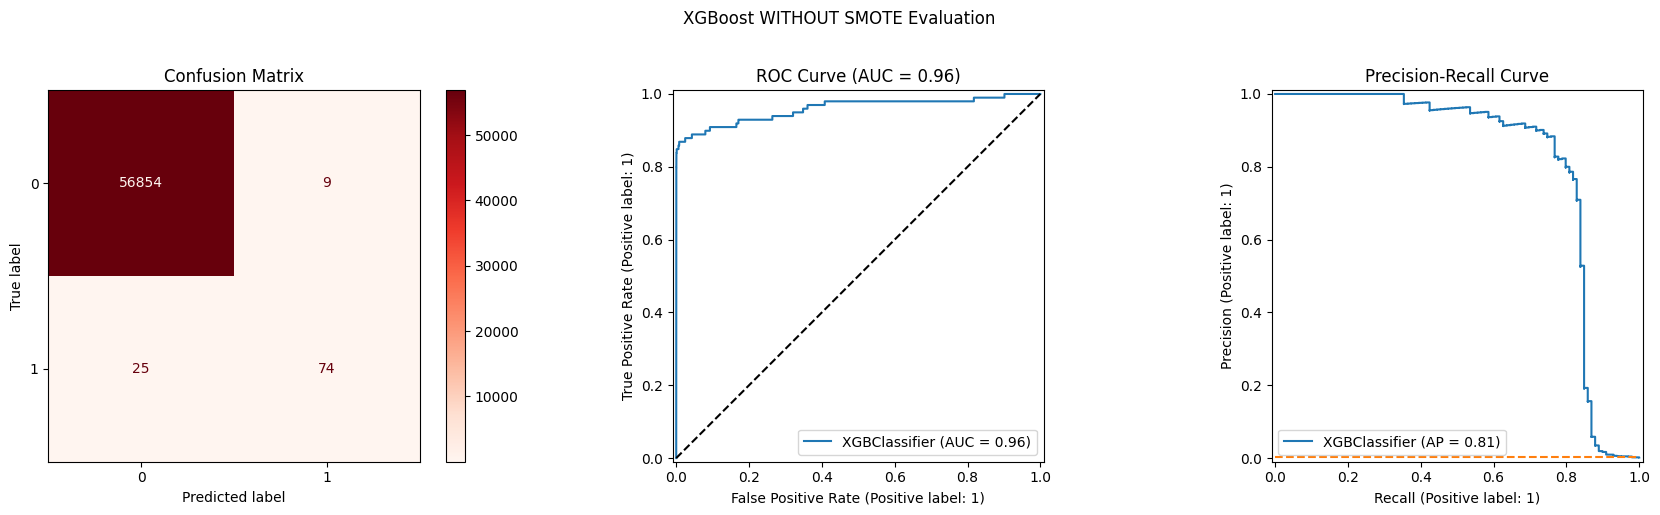


Random Forest Test Set Evaluation:
accuracy: 0.9994
precision: 0.8444
recall: 0.7677
f1: 0.8042
f3: 0.7747
roc_auc: 0.9554


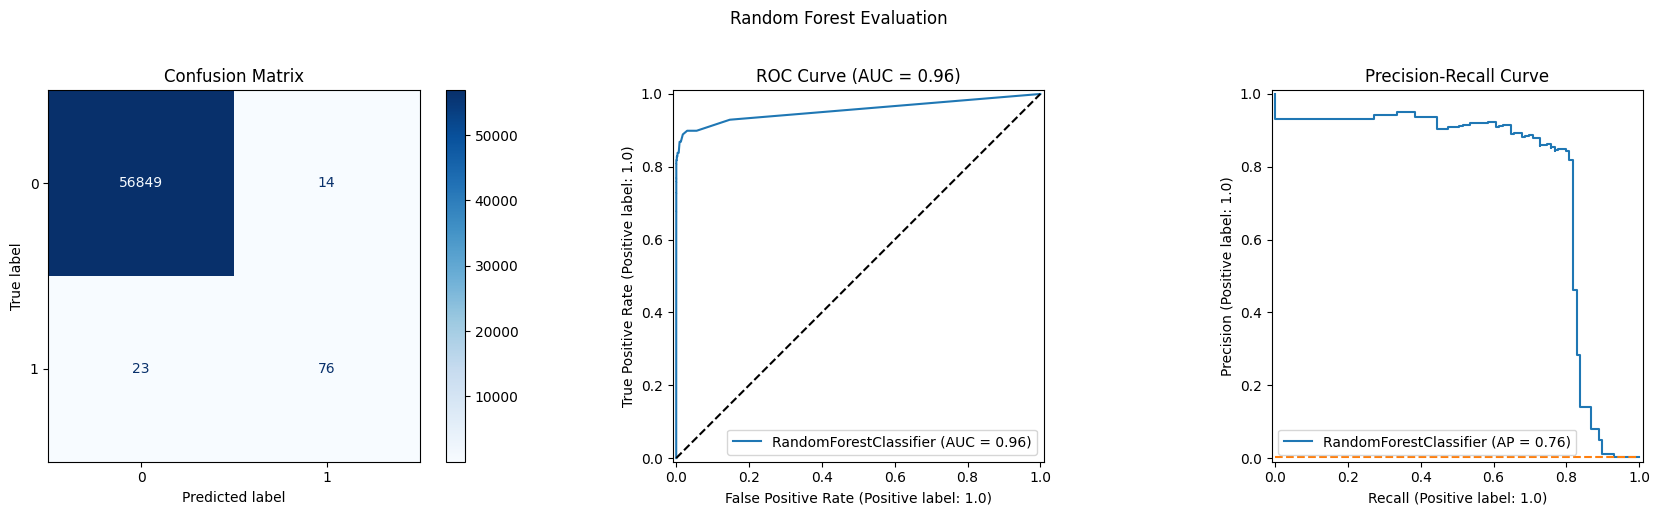

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:06:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Test Set Evaluation:
accuracy: 0.9991
precision: 0.7091
recall: 0.7879
f1: 0.7464
f3: 0.7792
roc_auc: 0.9576


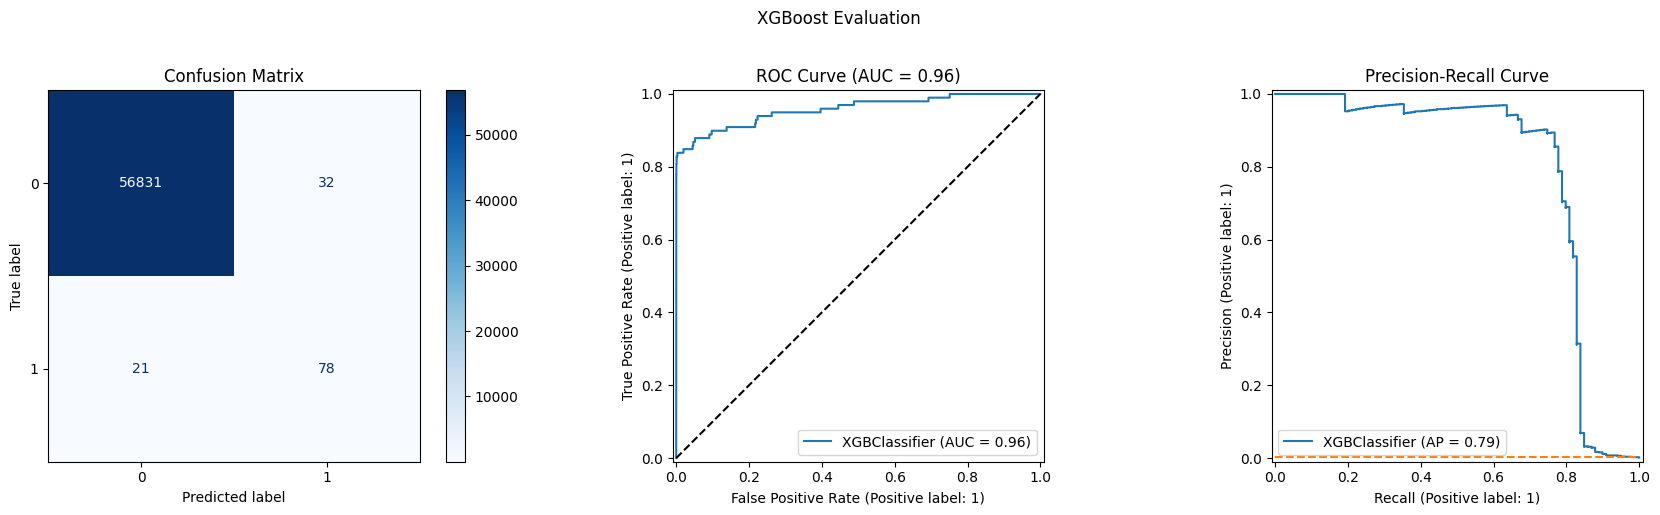

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "XGBoost": XGBClassifier(random_state=123, eval_metric='logloss', use_label_encoder=False)
}

for name, model in models.items():
    model_smote = clone(model)
    model_no_smote = clone(model)


    smote_metrics = evaluate_with_smote(model_smote, name, X_train, y_train, X_test, y_test)
    no_smote_metrics = evaluate_without_smote(model_no_smote, name, X_train, y_train, X_test, y_test)

for name, model in models.items():
    evaluate_model(model, name, X_train_resampled, y_train_resampled, X_test, y_test)

In [ ]:
#NIE MOŻNA TEGO ODKOMENTOWAĆ - kod się długo odpala, walidacja krzyżowa
# setup(data=df_vis, target='Class', session_id=1, fold=3)
# models_without_smote = compare_models()

,Description,Value
0,Session id,1
1,Target,Class
2,Target type,Binary
3,Original data shape,"(170883, 30)"
4,Transformed data shape,"(170883, 30)"
5,Transformed train set shape,"(119618, 30)"
6,Transformed test set shape,"(51265, 30)"
7,Numeric features,29
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9996,0.9686,0.7963,0.9455,0.8631,0.8629,0.8668,2.0800
rf,Random Forest Classifier,0.9995,0.9376,0.7575,0.9227,0.8299,0.8296,0.8347,59.9967
et,Extra Trees Classifier,0.9995,0.9422,0.7575,0.9366,0.8362,0.8360,0.8414,6.8033
lda,Linear Discriminant Analysis,0.9994,0.9821,0.7624,0.8652,0.8083,0.8080,0.8107,0.6300
lr,Logistic Regression,0.9992,0.9775,0.6362,0.8616,0.7308,0.7304,0.7394,10.3767
ada,Ada Boost Classifier,0.9992,0.9634,0.6996,0.8251,0.7537,0.7533,0.7576,24.8633
knn,K Neighbors Classifier,0.9991,0.8591,0.5244,0.8794,0.6565,0.6560,0.6784,37.7633
dt,Decision Tree Classifier,0.9991,0.8567,0.7138,0.7417,0.7261,0.7256,0.7264,6.5700
svm,SVM - Linear Kernel,0.9991,0.8334,0.6115,0.8448,0.7023,0.7019,0.7146,0.9967
ridge,Ridge Classifier,0.9989,0.9821,0.4324,0.8290,0.5662,0.5657,0.5970,0.3367


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
# NIE ODKOMETOWYWAĆ

# setup(data=X_n, target='Class', session_id=42, fold=3, fix_imbalance=True, use_gpu=True)
# models_with_smote = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(170883, 20)"
4,Transformed data shape,"(290089, 20)"
5,Transformed train set shape,"(238824, 20)"
6,Transformed test set shape,"(51265, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9994,0.9602,0.8012,0.8294,0.8129,0.8126,0.8138,7.8733
xgboost,Extreme Gradient Boosting,0.9992,0.9759,0.7963,0.7458,0.7683,0.7679,0.7692,1.3533
lightgbm,Light Gradient Boosting Machine,0.9990,0.9588,0.7818,0.6847,0.7281,0.7276,0.7302,2.8733
dummy,Dummy Classifier,0.9983,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3667
dt,Decision Tree Classifier,0.9976,0.8777,0.7574,0.3911,0.5157,0.5146,0.5432,7.2167
gbc,Gradient Boosting Classifier,0.9930,0.9709,0.8302,0.1753,0.2894,0.2874,0.3796,157.2100
ada,Ada Boost Classifier,0.9848,0.9665,0.8642,0.0907,0.1641,0.1615,0.2771,29.7133
lda,Linear Discriminant Analysis,0.9838,0.9634,0.8107,0.0880,0.1575,0.1548,0.2611,0.5600
nb,Naive Bayes,0.9797,0.9563,0.8253,0.0664,0.1229,0.1201,0.2307,0.3800
qda,Quadratic Discriminant Analysis,0.9715,0.9646,0.8495,0.0493,0.0932,0.0903,0.2007,0.8933


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

[2025-04-14 22:36:11.514] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


# Wnioski
Model, który osiągnął najwyższą metrykę F3 jest XGBoost. Teraz zajmiemy się bardziej zawaansowanym tuningiem hiperparametrycznym.

In [ ]:
f3_scorer = make_scorer(fbeta_score, beta=3, average='binary')

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'eval_metric': 'logloss'  # tylko dla wewnętrznego logowania XGBoost, nie dla Optuny
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring=f3_scorer, cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best params:", study.best_params)


[I 2025-05-06 06:40:34,939] A new study created in memory with name: no-name-f0b030e9-e7a9-4c74-bdd6-7ffde39d9f06
[I 2025-05-06 06:40:43,944] Trial 0 finished with value: 0.8041461447572633 and parameters: {'max_depth': 3, 'learning_rate': 0.16034517271509297, 'n_estimators': 223, 'subsample': 0.7454858271963991, 'colsample_bytree': 0.5373054289897692, 'gamma': 0.8000311008550115, 'reg_alpha': 0.2671631340939511, 'reg_lambda': 0.3947809512548358, 'scale_pos_weight': 7.186650435475091}. Best is trial 0 with value: 0.8041461447572633.
[I 2025-05-06 06:40:58,676] Trial 1 finished with value: 0.8023598130787369 and parameters: {'max_depth': 10, 'learning_rate': 0.026595341235733365, 'n_estimators': 293, 'subsample': 0.7040352561031267, 'colsample_bytree': 0.5543568537071719, 'gamma': 0.14140548314989232, 'reg_alpha': 0.018561364695782734, 'reg_lambda': 0.7723843757544763, 'scale_pos_weight': 3.2541087234362602}. Best is trial 0 with value: 0.8041461447572633.
[I 2025-05-06 06:41:07,302] Tr

Best params: {'max_depth': 3, 'learning_rate': 0.23505854864566095, 'n_estimators': 429, 'subsample': 0.9731517271049864, 'colsample_bytree': 0.8366165336407989, 'gamma': 3.9667957877657454, 'reg_alpha': 0.4237781896227466, 'reg_lambda': 0.20877607260377617, 'scale_pos_weight': 8.931144371113234}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost WITH SMOTE - Test Set Evaluation:
accuracy: 0.9984
precision: 0.5229
recall: 0.8081
f1: 0.6349
f3: 0.7663
roc_auc: 0.9612


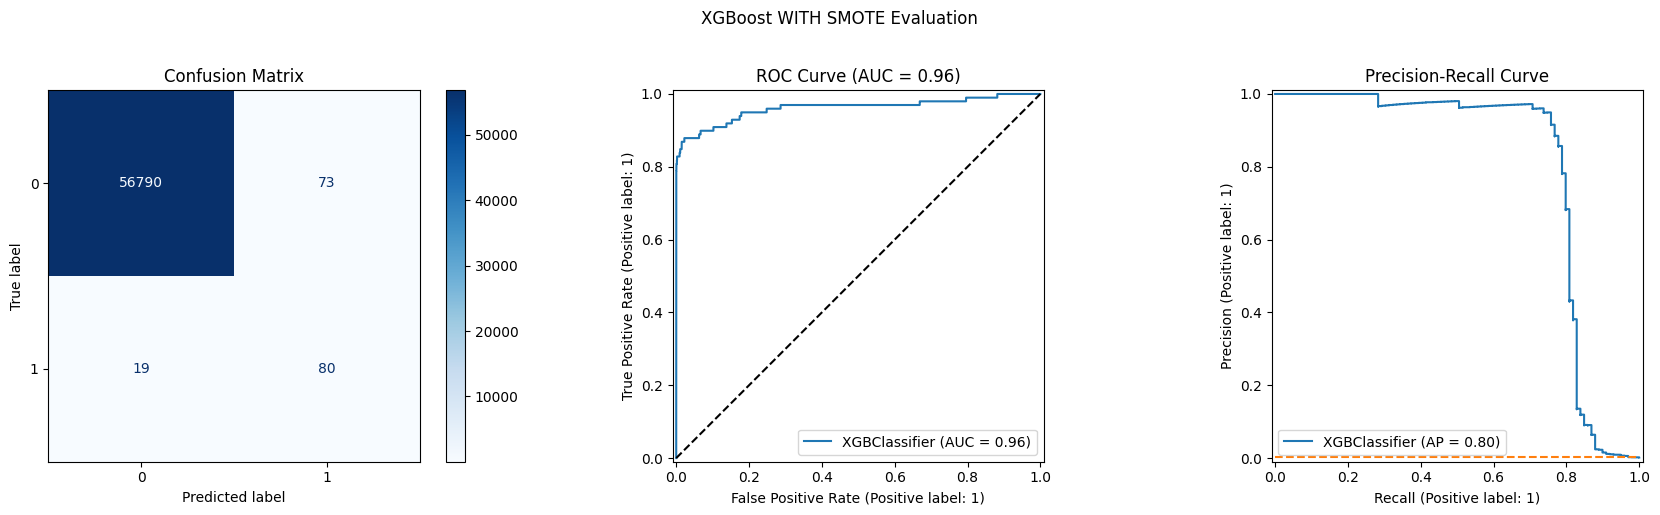

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:51:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost WITHOUT SMOTE - Test Set Evaluation:
accuracy: 0.9995
precision: 0.9167
recall: 0.7778
f1: 0.8415
f3: 0.7897
roc_auc: 0.9713


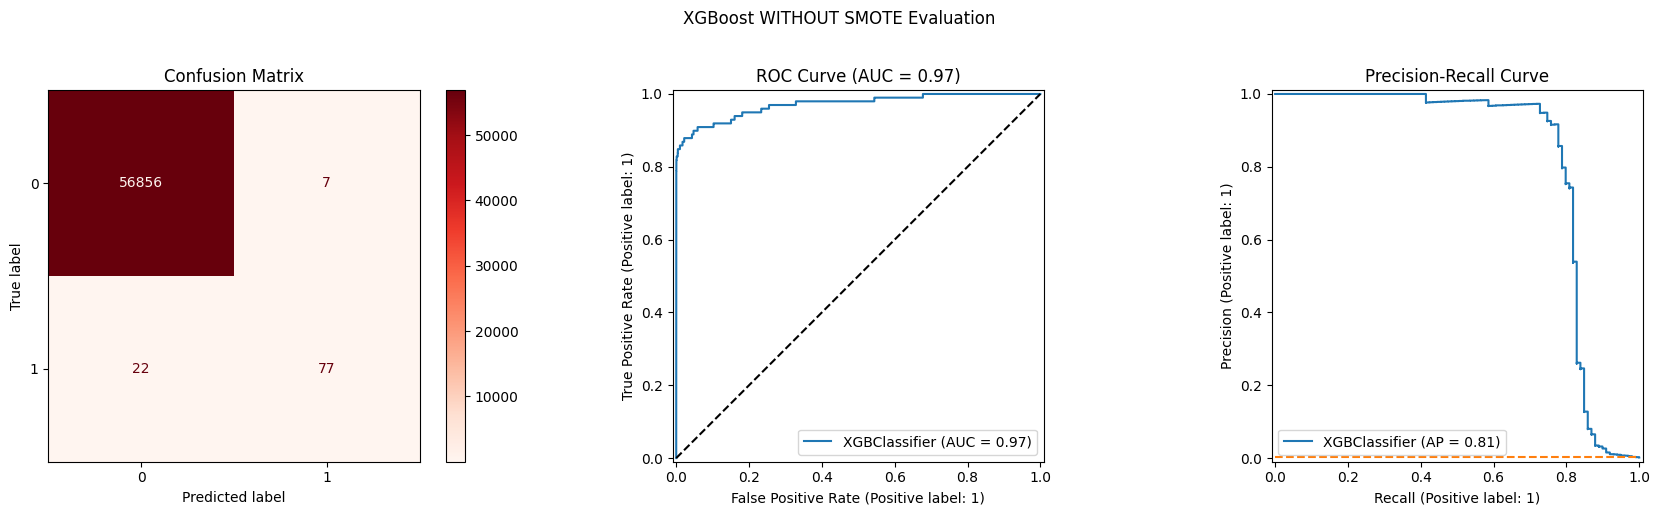

In [ ]:
best_params = {
    'max_depth': 9,
    'learning_rate': 0.18621580785890407,
    'n_estimators': 262,
    'subsample': 0.7303176441936332,
    'colsample_bytree': 0.7035584732125516,
    'gamma': 2.8051873692869043,
    'reg_alpha': 0.7249167235806886,
    'reg_lambda': 0.7282226979558069,
    'scale_pos_weight': 7.984040814153703,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}


model = XGBClassifier(**best_params)

models = {
    "XGBoost": model
}

for name, model in models.items():
    model_smote = clone(model)
    model_no_smote = clone(model)


    smote_metrics = evaluate_with_smote(model_smote, name, X_train, y_train, X_test, y_test)
    no_smote_metrics = evaluate_without_smote(model_no_smote, name, X_train, y_train, X_test, y_test)


In [ ]:
best_params = {'max_depth': 9,
               'learning_rate': 0.18621580785890407,
               'n_estimators': 262,
               'subsample': 0.7303176441936332,
               'colsample_bytree': 0.7035584732125516,
               'gamma': 2.8051873692869043,
               'reg_alpha': 0.7249167235806886,
               'reg_lambda': 0.7282226979558069,
               'scale_pos_weight': 7.984040814153703
               }


best_params['use_label_encoder'] = False

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

fraud_proba = model.predict_proba(X_test)[:, 1]  # Fraud probabilities
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:52:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
100%|===================| 170834/170883 [05:33<00:00]       

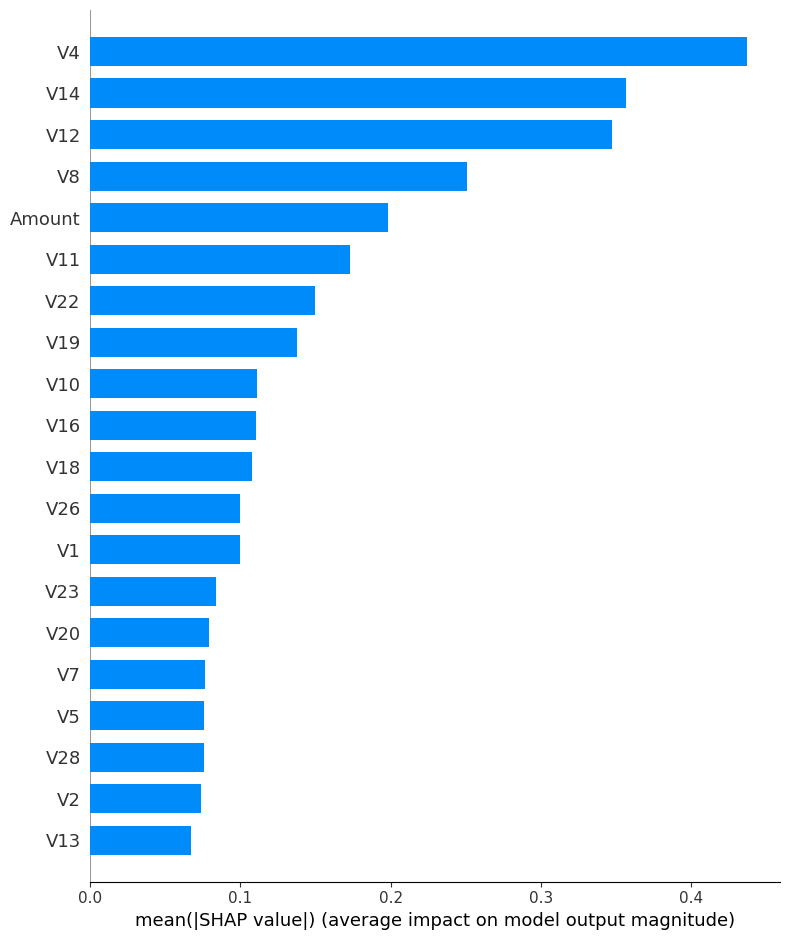

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)


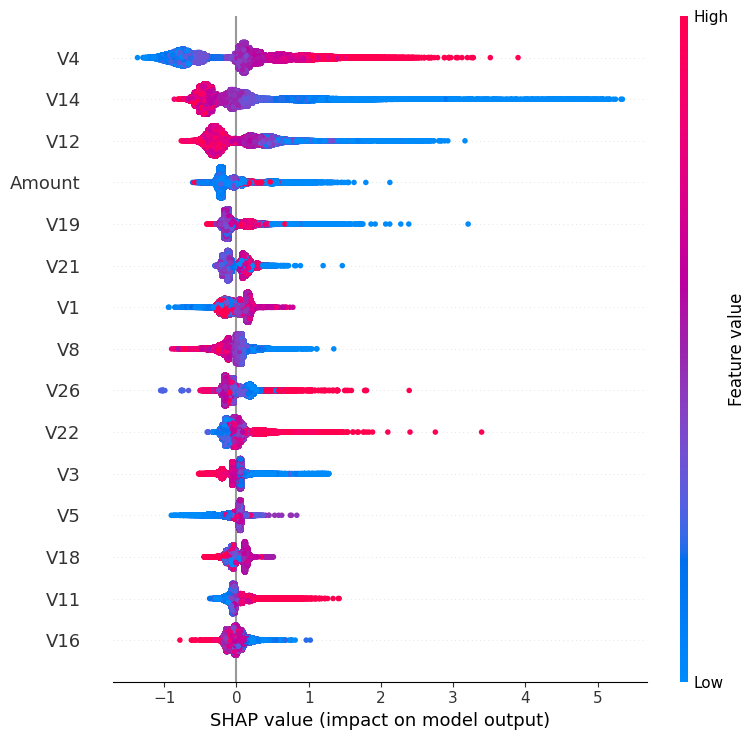

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=15)

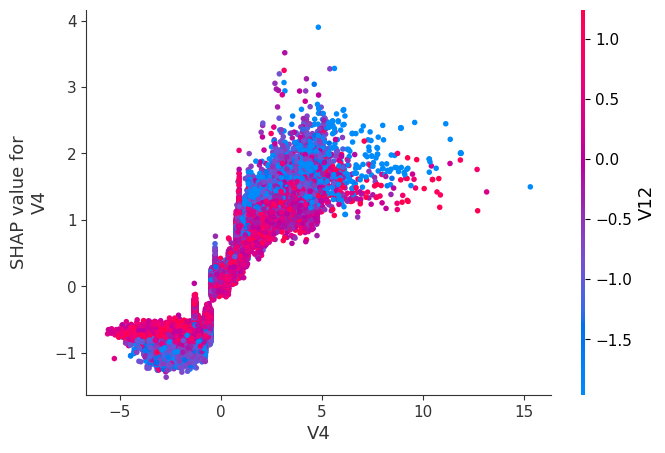

In [ ]:
shap.dependence_plot("V4", shap_values.values, X_train)


=== Transakcja #1 ===
Index: 10807
Prawdopodobieństwo oszustwa: 99.89%


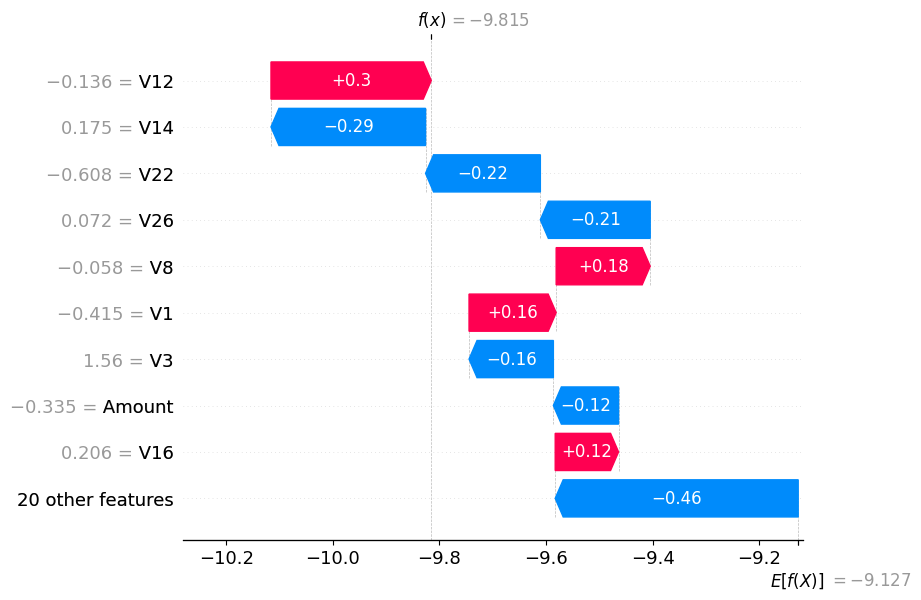


=== Transakcja #2 ===
Index: 55973
Prawdopodobieństwo oszustwa: 99.88%


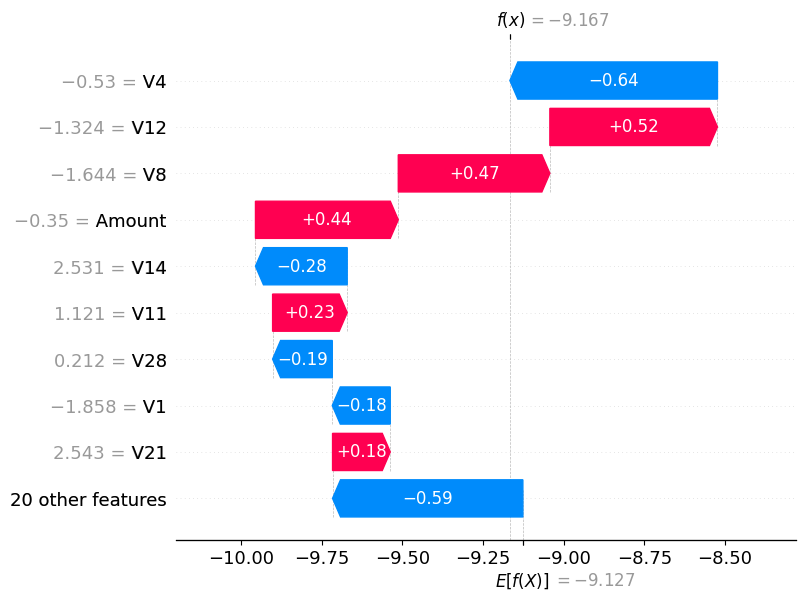


=== Transakcja #3 ===
Index: 48120
Prawdopodobieństwo oszustwa: 99.87%


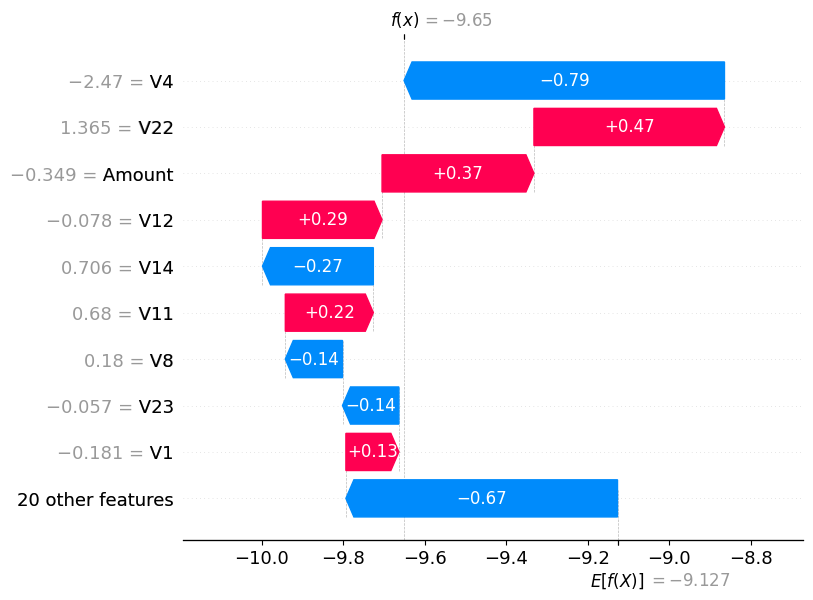


=== Transakcja #4 ===
Index: 747
Prawdopodobieństwo oszustwa: 99.87%


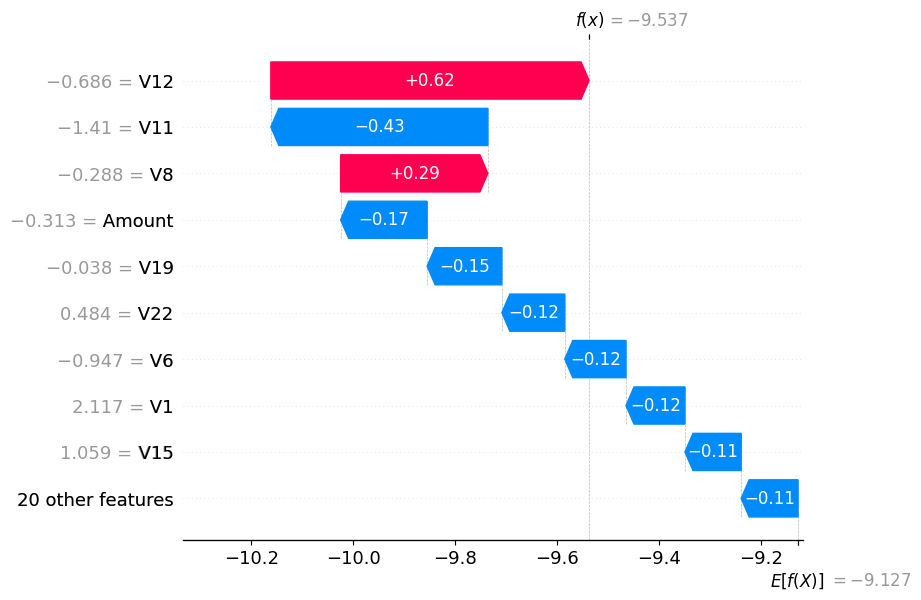

In [ ]:

# Oblicz prawdopodobieństwa oszustwa
fraud_proba = model.predict_proba(X_test)[:, 1]

# Znajdź indeksy 4 najwyższych prawdopodobieństw
top_indices = np.argsort(fraud_proba)[-4:][::-1]  # Posortowane malejąco

# Dla każdej z 4 transakcji wyświetl szczegóły i wykres
for i, index in enumerate(top_indices):
    observation = X_test.iloc[[index]]
    proba = fraud_proba[index]

    print(f"\n=== Transakcja #{i+1} ===")
    print(f"Index: {index}")
    print(f"Prawdopodobieństwo oszustwa: {proba:.2%}")

    shap.plots.waterfall(shap_values[index], max_display=10)
